# Mask R-CNN

A quick intro to using the pre-trained model to detect and segment objects.

In [1]:
import os
import sys

import random
import math
import numpy as np
import pandas as pd

import skimage.io
import cv2

import matplotlib
import matplotlib.pyplot as plt

from pathlib import Path

# Root directory of the project
HOME_DIR = str(Path.home())
RCNN_ROOT_DIR = os.path.abspath('mrcnn')

print(HOME_DIR)
print(RCNN_ROOT_DIR)

/home/jovyan
/home/jovyan/HICO/hico_det_paired_proposals/mrcnn


In [2]:
# Import Mask RCNN
sys.path.append(RCNN_ROOT_DIR)  # To find local version of the library
import mrcnn.utils as utils
import mrcnn.model as modellib
from mrcnn import visualize

%matplotlib inline 

Using TensorFlow backend.


In [3]:
# Import COCO config
sys.path.append(os.path.join(RCNN_ROOT_DIR, "samples/coco/"))  # To find local version
import coco

# Directory to save logs and trained model
MODEL_DIR = os.path.join(RCNN_ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(RCNN_ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Non-max suppression threshold to filter RPN proposals.
    # You can increase this during training to generate more propsals.
    RPN_NMS_THRESHOLD = 0.9
    
    # Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.5
    
    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.95

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.95
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           coco
NUM_CLASSES                    81
POOL_SIZE                     

## Create Model and Load Trained Weights

In [5]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [6]:
# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [7]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [8]:
len(class_names)

81

# Set image sources

In [9]:
# Directory of images to run detection on
COCO_IMAGE_DIR = os.path.join(HOME_DIR, "projectdata/pixnet01/pixnet01/pix_data/image")
HICO_IMAGE_DIR = os.path.join(HOME_DIR, "projectdata/cht01/hico_20160224_det/images/train2015")

# IMAGE_DIR = COCO_IMAGE_DIR
IMAGE_DIR = HICO_IMAGE_DIR

In [10]:
image_list = os.listdir(IMAGE_DIR)
len(image_list)

38118

## Test Object Detection

In [11]:
# Load a random image from the images folder
# file_names = next(os.walk(IMAGE_DIR))[2]
# image_name = image_list[0]
image_name = 'HICO_train2015_00000001.jpg'
image_path = os.path.join(IMAGE_DIR, image_name)
image = skimage.io.imread(image_path)

# if image is grayscale, transfer it to rgb
if(len(image.shape) < 3):
    image = skimage.color.gray2rgb(image)

In [12]:
image.shape

(480, 640, 3)

In [13]:
import time

start = time.time()
# Run detection
results = model.detect([image], verbose=1)
print(time.time() - start)

Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
3.1868090629577637


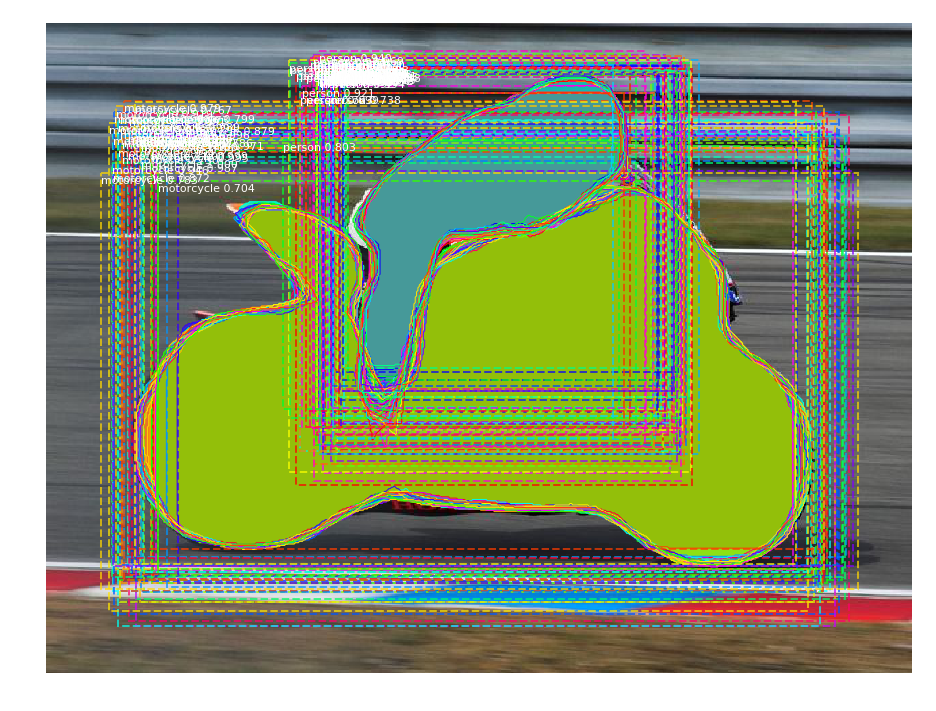

In [14]:
# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])

In [15]:
def DetectHumanAndObject(detector, img_path):
    input_img = skimage.io.imread(image_path)
    
    # transfer gray to rgb
    if(len(input_img.shape) < 3):
        input_img = skimage.color.gray2rgb(input_img)
    
    results = detector.detect([input_img], verbose=0)
    r = results[0]
    
    human_bboxs = []
    human_scores = []
    obj_bboxs = []
    obj_class_ids = []
    obj_scores = []
    
    for i in range(len(r['rois'])):
        class_id = r['class_ids'][i]
        class_score = r['scores'][i]
        roi = r['rois'][i] # [y1, x1, y2, x2]
        roi_new = [roi[1], roi[3], roi[0], roi[2]] # (x1, x2, y1, y2)

        if(class_id > 0):
            if(class_id == 1): # is human
                human_bboxs.append(roi_new)
                human_scores.append(class_score)
            else: # other object
                obj_bboxs.append(roi_new)
                obj_class_ids.append(class_id)
                obj_scores.append(class_score)
                
    return (human_bboxs, human_scores, obj_bboxs, obj_class_ids, obj_scores)


In [16]:
detect_res = DetectHumanAndObject(model, image_path)
human_bboxs = detect_res[0] 
obj_bboxs = detect_res[2]
obj_class_ids = detect_res[3]

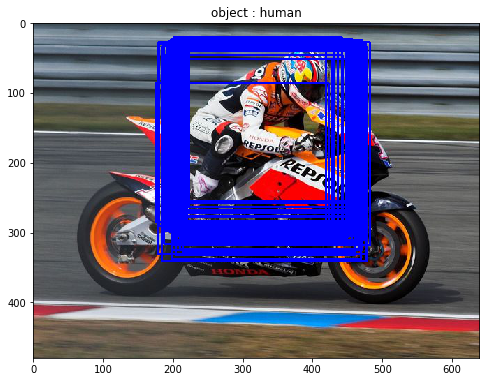

In [17]:
input_img = cv2.imread(image_path)
RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
for i in range(len(human_bboxs)):    
    roi = human_bboxs[i]
    cv2.rectangle(RGB_img, 
                  (roi[0], roi[2]), 
                  (roi[1], roi[3]), 
                  (0,0,255), 2)
    
# show image and bbox
fig = plt.figure(figsize=(8,8))
plt.title('object : {}'.format('human'))
plt.imshow(RGB_img)
plt.show()

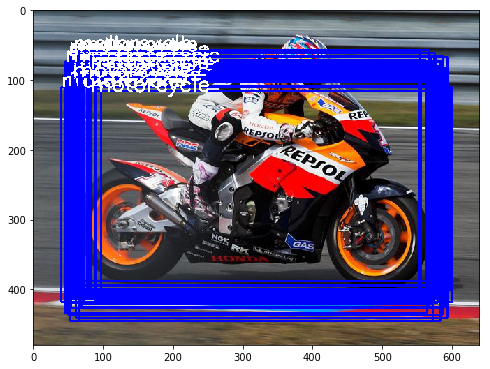

In [18]:
input_img = cv2.imread(image_path)
RGB_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
for i in range(len(obj_bboxs)):
    roi = obj_bboxs[i]
    cv2.rectangle(RGB_img, 
                  (roi[0], roi[2]), 
                  (roi[1], roi[3]), 
                  (0,0,255), 2)
    
    class_id = obj_class_ids[i]
    class_name = class_names[class_id]
    cv2.putText(RGB_img,
                class_name, 
                (roi[0], roi[2]), 
                cv2.FONT_HERSHEY_SIMPLEX, 
                1, # font scale
                (255,255,255), # color
                2,
                lineType=2)
    
# show image and bbox
fig = plt.figure(figsize=(8,8))
plt.imshow(RGB_img)
plt.show()

In [19]:
def CreateHumanObjPairedInfo(human_bboxs, obj_bboxs, obj_class_ids):
    pair_bboxs = []
    pair_o_class_ids = []
    for h_i in range(len(human_bboxs)):
        for o_i in range(len(obj_bboxs)):
            pair_bboxs.append([human_bboxs[h_i], obj_bboxs[o_i]])
            pair_o_class_ids.append(obj_class_ids[o_i])
    return np.array(pair_bboxs), np.array(pair_o_class_ids)

In [20]:
def CreateProposalDataframe(img_name, paired_bbox, paired_obj_class_ids):
    h_bboxs, o_bboxs, o_cids = [], [], []
    if(len(paired_bbox) > 0):
        h_bboxs = paired_bbox[:,0].tolist()
        o_bboxs = paired_bbox[:,1].tolist()
        o_cids = paired_obj_class_ids
        
    df = pd.DataFrame({
        'human_bbox' : h_bboxs,
        'obj_bbox' : o_bboxs,
        'name' : image_name,
        'obj_class_id' : o_cids
    })
    df['human_bbox'] = df['human_bbox'].apply(lambda x : tuple(x))
    df['obj_bbox'] = df['obj_bbox'].apply(lambda x : tuple(x))
    return df

In [21]:
paired_bboxs, paired_obj_class_ids = CreateHumanObjPairedInfo(human_bboxs, obj_bboxs, obj_class_ids)
df_proposals = CreateProposalDataframe(image_name, paired_bboxs, paired_obj_class_ids)

In [22]:
df_proposals.head()

,human_bbox,name,obj_bbox,obj_class_id
0,"(206, 456, 38, 315)",HICO_train2015_00000001.jpg,"(60, 572, 92, 407)",4
1,"(206, 456, 38, 315)",HICO_train2015_00000001.jpg,"(70, 568, 86, 408)",4
2,"(206, 456, 38, 315)",HICO_train2015_00000001.jpg,"(70, 566, 98, 404)",4
3,"(206, 456, 38, 315)",HICO_train2015_00000001.jpg,"(68, 575, 82, 401)",4
4,"(206, 456, 38, 315)",HICO_train2015_00000001.jpg,"(77, 570, 92, 401)",4


# Detect all image bboxs and save to file

## Partially detect and save

In [39]:
all_det_bbox_data = []
df_det_human_all, df_det_obj_all = pd.DataFrame(), pd.DataFrame()
for i in range(len(image_list)):
    image_name = image_list[i]
    image_path = os.path.join(IMAGE_DIR, image_name)
    
    detect_res = DetectHumanAndObject(model, image_path)
    human_bboxs = detect_res[0] 
    human_scores = detect_res[1]
    obj_bboxs = detect_res[2]
    obj_class_ids = detect_res[3]
    obj_scores = detect_res[4]

    df_det_human = pd.DataFrame({
        'human_bbox' : human_bboxs,
        'human_score' : human_scores,
        'img_name' : image_name
    })

    df_det_obj = pd.DataFrame({
        'obj_bbox' : obj_bboxs,
        'obj_class_id' : obj_class_ids,
        'obj_score' : obj_scores,
        'img_name' : image_name
    })

    df_det_human_all = pd.concat(
        [df_det_human, df_det_human_all], axis=0, ignore_index=True)
    df_det_obj_all = pd.concat(
        [df_det_obj, df_det_obj_all], axis=0, ignore_index=True)
    
    img_num = i+1
    if((img_num) % 100 == 0):
        # save data
        df_det_human_all.to_csv('det_results/det_human_all_{}.csv'.format(img_num))
        df_det_obj_all.to_csv('det_results/det_obj_all_{}.csv'.format(img_num))
        
        # clear data
        df_det_human_all = df_det_human_all.iloc[0:0] 
        df_det_obj_all = df_det_obj_all.iloc[0:0]
        
        print('{} / {}'.format(img_num, len(image_list)))

# save data
df_det_human_all.to_csv('det_results/det_human_all_final.csv')
df_det_obj_all.to_csv('det_results/det_obj_all_final.csv')

100 / 38118
200 / 38118
300 / 38118
600 / 38118
700 / 38118
800 / 38118
900 / 38118
1000 / 38118
1100 / 38118
1200 / 38118
1300 / 38118
1400 / 38118
1500 / 38118
1600 / 38118
1700 / 38118
1800 / 38118
1900 / 38118
2000 / 38118
2100 / 38118
2200 / 38118
2300 / 38118
2400 / 38118
2500 / 38118
2600 / 38118
2700 / 38118
2800 / 38118
2900 / 38118
3000 / 38118
3100 / 38118
3200 / 38118
3300 / 38118
3400 / 38118
3500 / 38118
3600 / 38118
3700 / 38118
3800 / 38118
3900 / 38118
4000 / 38118
4100 / 38118
4200 / 38118
4300 / 38118
4400 / 38118
4500 / 38118
4600 / 38118
4700 / 38118
4800 / 38118
4900 / 38118
5000 / 38118
5100 / 38118
5200 / 38118
5300 / 38118
5400 / 38118
5500 / 38118
5600 / 38118
5700 / 38118
5800 / 38118
5900 / 38118
6000 / 38118
6100 / 38118
6200 / 38118
6300 / 38118
6400 / 38118
6500 / 38118
6600 / 38118
6700 / 38118
6800 / 38118
6900 / 38118
7000 / 38118
7100 / 38118
7200 / 38118
7300 / 38118
7400 / 38118
7500 / 38118
7600 / 38118
7700 / 38118
7800 / 38118
7900 / 38118
8000 /

## Combine all detected result to one file

In [40]:
import re

f_list = os.listdir('det_results') # files in current dir

# get all files
f_det_human_all = []
f_det_obj_all = []

for f_name in f_list:
    mat_res = re.match('det_human_all_', f_name)
    if(mat_res != None):
        f_det_human_all.append(f_name)
    mat_res = re.match('det_obj_all_', f_name)
    if(mat_res != None):
        f_det_obj_all.append(f_name)

In [41]:
print(len(f_det_human_all), len(f_det_obj_all))

382 382


In [42]:
df_det_human_all = pd.DataFrame()
for f_det_human in f_det_human_all:
    df_det_human = pd.DataFrame.from_csv('det_results/' + f_det_human)
    df_det_human_all = pd.concat([df_det_human_all, df_det_human], axis=0, ignore_index=True)

df_det_obj_all = pd.DataFrame()
for f_det_obj in f_det_obj_all:
    df_det_obj = pd.DataFrame.from_csv('det_results/' + f_det_obj)
    df_det_obj_all = pd.concat([df_det_obj_all, df_det_obj], axis=0, ignore_index=True)

In [43]:
print(df_det_human_all['img_name'].unique().shape)
print(df_det_obj_all['img_name'].unique().shape)

(37738,)
(36701,)


In [44]:
print(df_det_human_all.shape)
print(df_det_obj_all.shape)

(1826510, 3)
(1608926, 4)


### save file

In [45]:
df_det_human_all.to_csv('det_human_all_concat.csv')
df_det_obj_all.to_csv('det_obj_all_concat.csv')